**Reddit**

In [ ]:
!pip install praw pandas
!pip install python-dotenv

In [ ]:
import praw
import pandas as pd
import datetime
import time
import requests
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from google.colab import files

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path='Reddit_Credential.env')

reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent=os.getenv("REDDIT_USER_AGENT"),
    username=os.getenv("REDDIT_USERNAME"),
    password=os.getenv("REDDIT_PASSWORD")
)

print(f"Logged in as: {reddit.user.me()}")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Logged in as: Win_Natcha


In [ ]:
SUBREDDIT_NAME = "airbnb"
START_DATE = datetime.datetime(2024, 7, 1)
END_DATE = datetime.datetime(2025, 6, 30)
OUTPUT_FILENAME = f"{SUBREDDIT_NAME}_raw_data.csv"

start_timestamp = START_DATE.timestamp()
end_timestamp = END_DATE.timestamp()

raw_data_list = []
seen_post_ids = set()

def clean_text(text):
    if isinstance(text, str):
        text = unicodedata.normalize("NFKD", text).strip()
    return text

subreddit = reddit.subreddit(SUBREDDIT_NAME)
print(f"Fetching posts from r/{SUBREDDIT_NAME}...")

posts_to_process = list(subreddit.hot(limit=None)) + \
                   list(subreddit.new(limit=None)) + \
                   list(subreddit.top(limit=None))

print(f"Found {len(posts_to_process)} posts (including potential duplicates). Processing...")

for post in posts_to_process:
    if post.id in seen_post_ids:
        continue
    seen_post_ids.add(post.id)

    time.sleep(2)

    if start_timestamp <= post.created_utc <= end_timestamp:
        raw_data_list.append({
            "timestamp": post.created_utc,
            "post_id": post.id,
            "comment_id": None,
            "post_title": clean_text(post.title),
            "post_body": clean_text(post.selftext),
            "comment_body": None,
            "upvotes": post.score,
            "source_type": "Post"
        })

    post.comments.replace_more(limit=0)
    for comment in post.comments:
        if isinstance(comment, praw.models.Comment):
            if comment.body not in ["[removed]", "[deleted]"]:
                if start_timestamp <= comment.created_utc <= end_timestamp:
                    raw_data_list.append({
                        "timestamp": comment.created_utc,
                        "post_id": post.id,
                        "comment_id": comment.id,
                        "post_title": clean_text(post.title),
                        "post_body": None,
                        "comment_body": clean_text(comment.body),
                        "upvotes": comment.score,
                        "source_type": "Comment"
                    })

df_raw = pd.DataFrame(raw_data_list)
df_raw['Timestamp'] = pd.to_datetime(df_raw['timestamp'], unit='s')
df_raw = df_raw.drop(columns=['timestamp'])

df_raw = df_raw[[
    'Timestamp', 'post_id', 'comment_id', 'post_title',
    'post_body', 'comment_body', 'upvotes', 'source_type'
]]

df_raw.to_csv(OUTPUT_FILENAME, index=False, encoding="utf-8-sig")

print(f"\nScraping complete. Saved {len(df_raw)} raw items to {OUTPUT_FILENAME}")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Fetching posts from r/airbnb...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Found 2739 posts (including potential duplicates). Processing...


Streaming output truncated to the last 5000 lines.
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.r


Scraping complete. Saved 10531 raw items to airbnb_raw_data.csv


In [ ]:
PROCESSED_DATA_FILE = "airbnb_analytical_dataset.csv"
RAW_DATA_FILE = "airbnb_raw_data.csv"
df = pd.read_csv(RAW_DATA_FILE)

processed_list = []

print("Processing data into final format...")
for index, row in df.iterrows():
    post_title = str(row['post_title']) if pd.notna(row['post_title']) else ""

    if row['source_type'] == 'Post':
        post_body = str(row['post_body']) if pd.notna(row['post_body']) else ""
        final_text = (post_title + " " + post_body).strip()

        if final_text:
            processed_list.append({
                "Timestamp": row['Timestamp'],
                "Text": final_text,
                "Upvotes": row['upvotes'],
                "Source": "Post"
            })

    elif row['source_type'] == 'Comment':
        comment_body = str(row['comment_body']) if pd.notna(row['comment_body']) else ""
        final_text = (post_title + " " + comment_body).strip()

        if final_text:
            processed_list.append({
                "Timestamp": row['Timestamp'],
                "Text": final_text,
                "Upvotes": row['upvotes'],
                "Source": "Comment"
            })

df_final = pd.DataFrame(processed_list)

df_final.drop_duplicates(subset=['Text'], inplace=True)
df_final.sort_values(by='Timestamp', inplace=True, ignore_index=True)

df_final.to_csv(PROCESSED_DATA_FILE, index=False, encoding="utf-8-sig")

print(f"\nProcessing complete. Saved {len(df_final)} unique data points to {PROCESSED_DATA_FILE}")
print("Final dataset is ready for analysis.")
df_final.head()

Processing data into final format...

Processing complete. Saved 10490 unique data points to airbnb_analytical_dataset.csv
Final dataset is ready for analysis.


,Timestamp,Text,Upvotes,Source
0,2024-07-01 02:37:03,"Host has camera facing the hot tub, calls me w...",2,Comment
1,2024-07-01 02:48:36,"Host has camera facing the hot tub, calls me w...",1,Comment
2,2024-07-01 13:52:49,"Host has camera facing the hot tub, calls me w...",2,Comment
3,2024-07-01 16:56:53,"Host has camera facing the hot tub, calls me w...",2,Comment
4,2024-07-02 00:04:10,"Host has camera facing the hot tub, calls me w...",1,Comment


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10490 entries, 0 to 10489
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  10490 non-null  object
 1   Text       10490 non-null  object
 2   Upvotes    10490 non-null  int64 
 3   Source     10490 non-null  object
dtypes: int64(1), object(3)
memory usage: 327.9+ KB


In [ ]:
df_final['Timestamp'] = pd.to_datetime(df_final['Timestamp'], errors='coerce')
df_final['Date'] = df_final['Timestamp'].dt.date
df_final['Time'] = df_final['Timestamp'].dt.time

print(df_final.head())
df_final.info()

df_final.to_csv("airbnb_reddit_data.csv", index=False, encoding="utf-8-sig")

            Timestamp                                               Text  \
0 2024-07-01 02:37:03  Host has camera facing the hot tub, calls me w...   
1 2024-07-01 02:48:36  Host has camera facing the hot tub, calls me w...   
2 2024-07-01 13:52:49  Host has camera facing the hot tub, calls me w...   
3 2024-07-01 16:56:53  Host has camera facing the hot tub, calls me w...   
4 2024-07-02 00:04:10  Host has camera facing the hot tub, calls me w...   

   Upvotes   Source        Date      Time  
0        2  Comment  2024-07-01  02:37:03  
1        1  Comment  2024-07-01  02:48:36  
2        2  Comment  2024-07-01  13:52:49  
3        2  Comment  2024-07-01  16:56:53  
4        1  Comment  2024-07-02  00:04:10  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10490 entries, 0 to 10489
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  10490 non-null  datetime64[ns]
 1   Text       10490 non-null

In [ ]:
df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"])

start_date = df_final["Timestamp"].min()
end_date = df_final["Timestamp"].max()

start_date, end_date

(Timestamp('2024-07-01 02:37:03'), Timestamp('2025-06-29 23:45:26'))

/tmp/ipython-input-16-3403724401.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df_final.set_index('Timestamp').resample('M').size()
/tmp/ipython-input-16-3403724401.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Count', data=monthly_counts_df, ax=ax, palette='viridis')


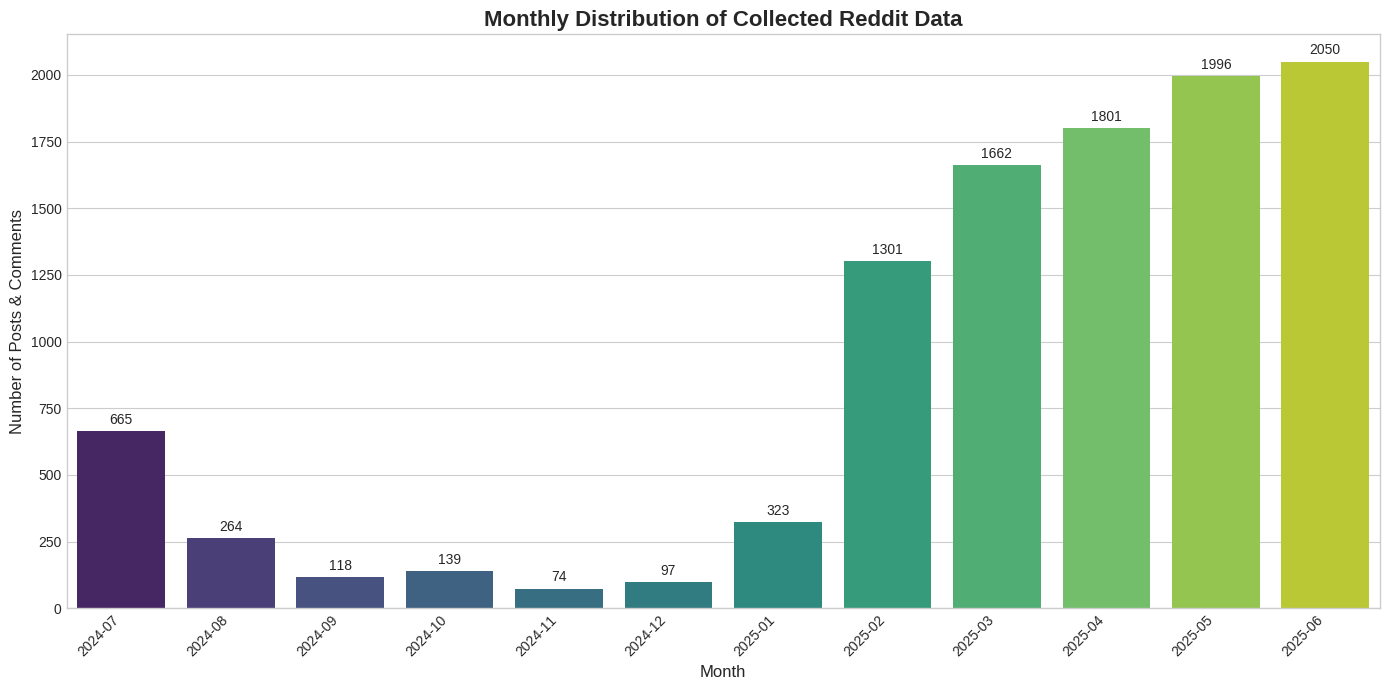

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_final['Timestamp'] = pd.to_datetime(df_final['Timestamp'])

monthly_counts = df_final.set_index('Timestamp').resample('M').size()

monthly_counts_df = monthly_counts.reset_index()
monthly_counts_df.columns = ['Month', 'Count']

monthly_counts_df['Month'] = monthly_counts_df['Month'].dt.strftime('%Y-%m')

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 7))

sns.barplot(x='Month', y='Count', data=monthly_counts_df, ax=ax, palette='viridis')

ax.set_title('Monthly Distribution of Collected Reddit Data', fontsize=16, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Posts & Comments', fontsize=12)

plt.xticks(rotation=45, ha='right')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10, padding=3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-18-788846944.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df_final_sorted.resample('M').size().reset_index()
/tmp/ipython-input-18-788846944.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


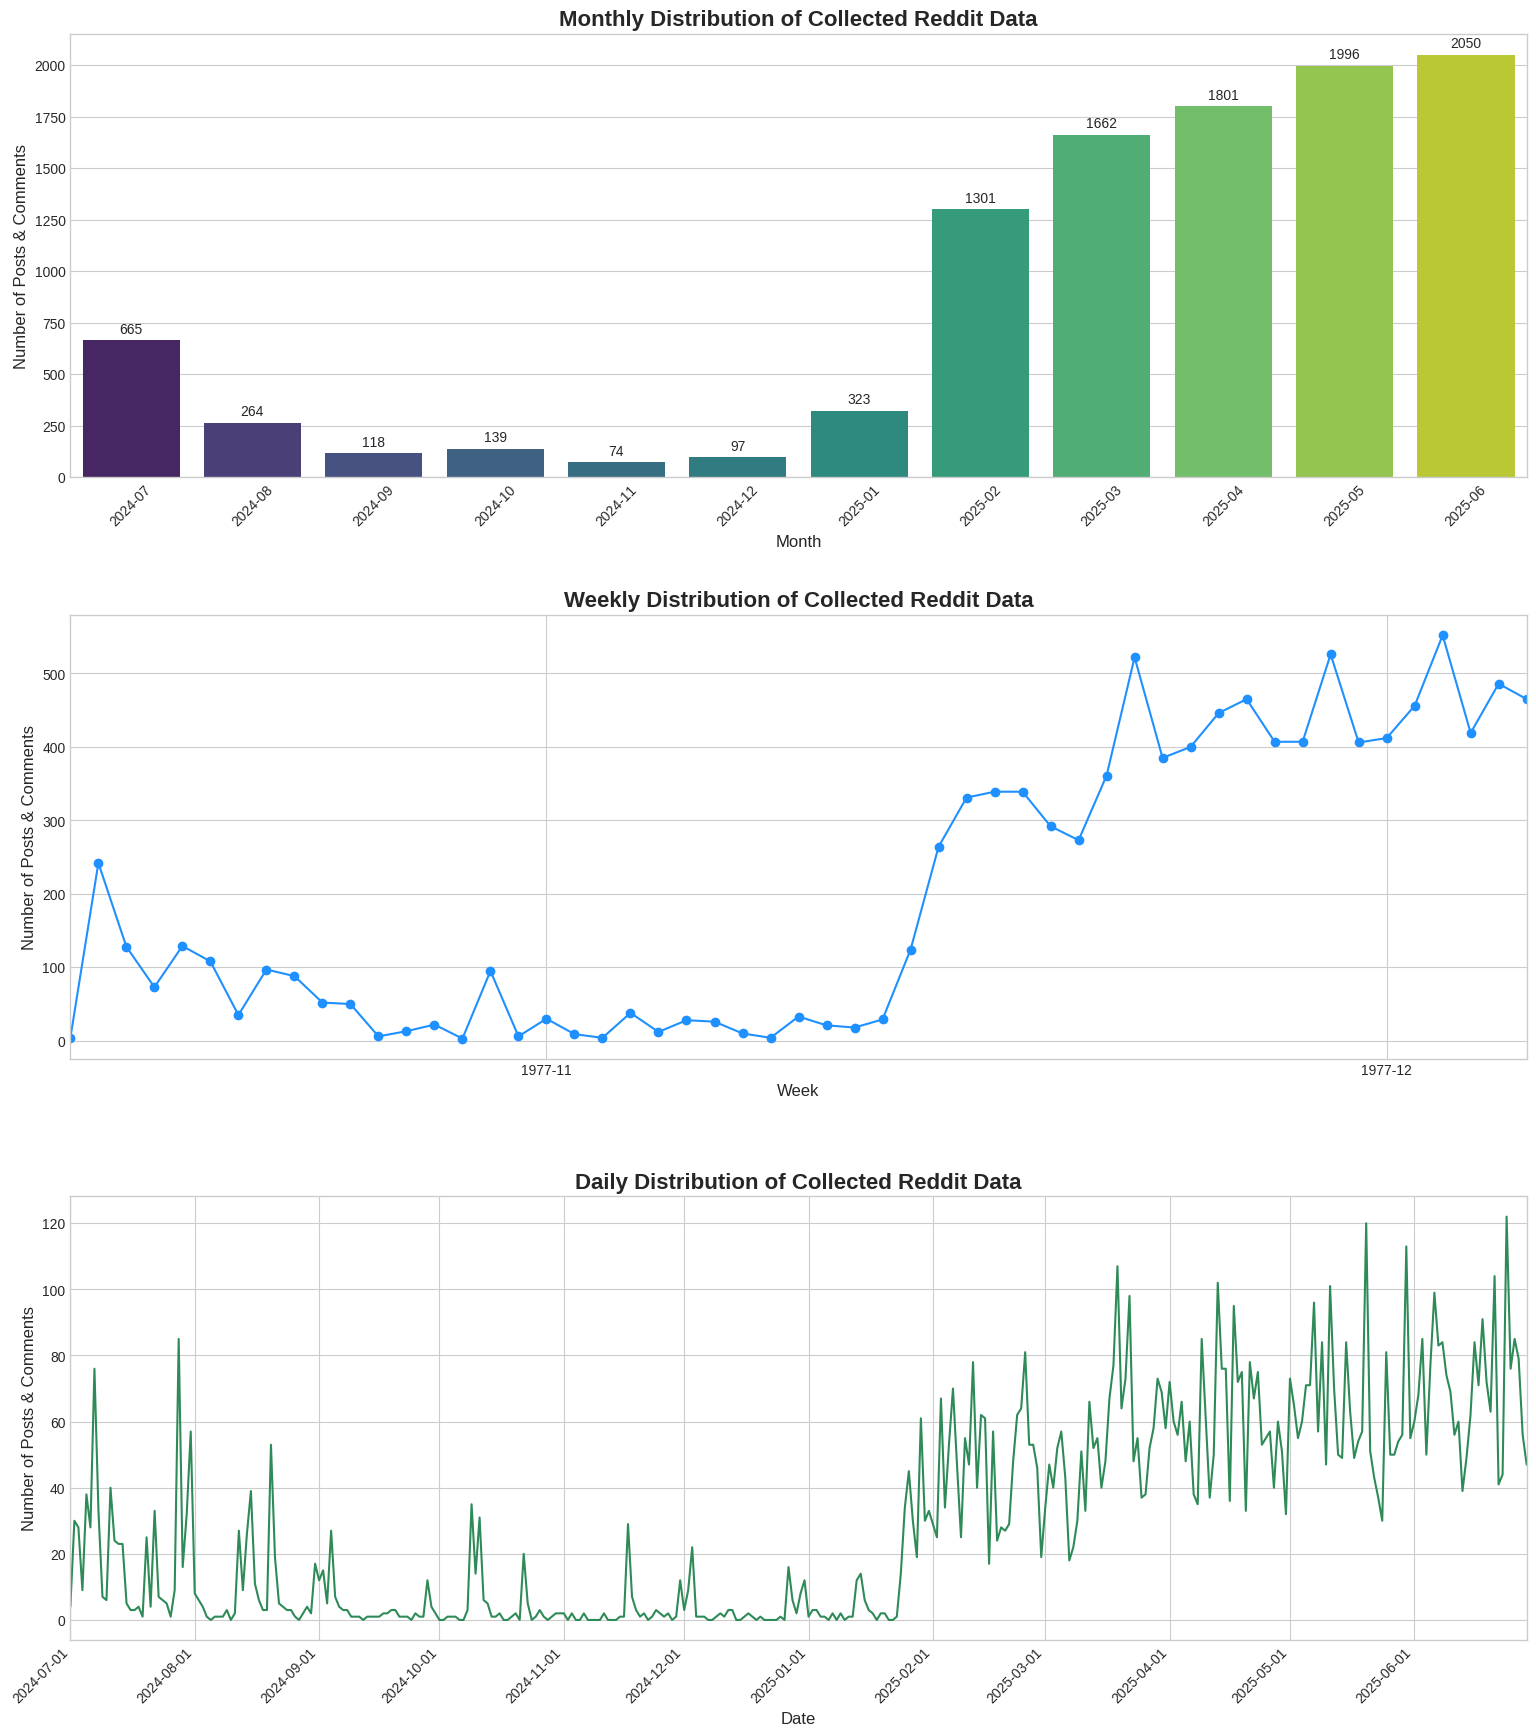

In [ ]:
import matplotlib.dates as mdates

df_final['Timestamp'] = pd.to_datetime(df_final['Timestamp'])
df_final_sorted = df_final.set_index('Timestamp').sort_index()

monthly_counts = df_final_sorted.resample('M').size().reset_index()
monthly_counts.columns = ['Month', 'Count']
monthly_counts['Month'] = monthly_counts['Month'].dt.strftime('%Y-%m')

weekly_counts = df_final_sorted.resample('W-Mon').size()
daily_counts = df_final_sorted.resample('D').size()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(16, 18))

sns.barplot(
    x='Month',
    y='Count',
    data=monthly_counts,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Monthly Distribution of Collected Reddit Data', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Number of Posts & Comments', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', fontsize=10, padding=3)

weekly_counts.plot(
    ax=axes[1],
    linestyle='-',
    marker='o',
    color='dodgerblue',
    legend=False
)
axes[1].set_title('Weekly Distribution of Collected Reddit Data', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Week', fontsize=12)
axes[1].set_ylabel('Number of Posts & Comments', fontsize=12)
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

daily_counts.plot(
    ax=axes[2],
    linestyle='-',
    color='seagreen',
    legend=False
)
axes[2].set_title('Daily Distribution of Collected Reddit Data', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Number of Posts & Comments', fontsize=12)
axes[2].xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(axes[2].get_xticklabels(), rotation=45, ha='right')

fig.tight_layout(pad=3.0)
plt.show()

**X (Twitter)**

In [ ]:
import tweepy
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAMaE3AEAAAAApYbr4ft3l%2BdfYzOhuDwTdzmLzkc%3DhKcKhteHAVTg8KmKQDNX7PUmfRM01B0KPf8RyWBVoajAudz3L2"

client = tweepy.Client(bearer_token=BEARER_TOKEN)
print("✅ Successfully connected to Twitter API v2.")

queries_to_count = [
    {
        "name": "Specific (AND)",
        "query": "(Airbnb @Airbnb #Airbnb) -is:retweet -has:links lang:en"
    },
    {
        "name": "Keyword & Mention (AND)",
        "query": "Airbnb @Airbnb -is:retweet -has:links lang:en"
    },
    {
        "name": "Broad (OR)",
        "query": "(Airbnb OR @Airbnb OR #Airbnb) -is:retweet -has:links lang:en"
    }
]

OVERALL_START_TIME = datetime.datetime(2024, 7, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)
OUTPUT_FILENAME = "twitter_monthly_counts_by_query.csv"

print(f"\n🔬 Getting tweet counts for each query and month...")
all_counts = []

for item in queries_to_count:
    query_name = item["name"]
    query_text = item["query"]

    print(f"\n--- Counting for Query: '{query_name}' ---")

    current_month_start = OVERALL_START_TIME
    for month_num in range(12):
        start_time = current_month_start
        end_time = start_time + relativedelta(months=1) - relativedelta(seconds=1)

        try:
            response = client.get_all_tweets_count(
                query=query_text,
                start_time=start_time,
                end_time=end_time
            )

            count = response.meta.get('total_tweet_count', 0)
            print(f"  - {start_time.strftime('%Y-%m')}: Found {count:,} tweets.")
            all_counts.append({
                "Month": start_time.strftime('%Y-%m'),
                "Query_Name": query_name,
                "Tweet_Count": count
            })

        except Exception as e:
            print(f"  - Could not get count for month {start_time.strftime('%Y-%m')}: {e}")
            all_counts.append({
                "Month": start_time.strftime('%Y-%m'),
                "Query_Name": query_name,
                "Tweet_Count": "Error"
            })

        current_month_start += relativedelta(months=1)

if all_counts:
    df_counts = pd.DataFrame(all_counts)
    df_counts.to_csv(OUTPUT_FILENAME, index=False)
    print(f"\n✅ Monthly counts saved to {OUTPUT_FILENAME}")

    print("\n--- Summary of Monthly Tweet Counts by Query ---")
    pivot_df = df_counts.pivot(index='Month', columns='Query_Name', values='Tweet_Count')
    print(pivot_df)
else:
    print("\nCould not retrieve any monthly counts.")

✅ Successfully connected to Twitter API v2.

🔬 Getting tweet counts for each query and month...

--- Counting for Query: 'Specific (AND)' ---
  - 2024-07: Found 89 tweets.
  - 2024-08: Found 75 tweets.
  - 2024-09: Found 99 tweets.
  - 2024-10: Found 91 tweets.
  - 2024-11: Found 38 tweets.
  - 2024-12: Found 69 tweets.
  - 2025-01: Found 62 tweets.
  - 2025-02: Found 39 tweets.
  - 2025-03: Found 64 tweets.
  - 2025-04: Found 37 tweets.
  - 2025-05: Found 57 tweets.
  - 2025-06: Found 66 tweets.

--- Counting for Query: 'Keyword & Mention (AND)' ---
  - 2024-07: Found 4,059 tweets.
  - 2024-08: Found 3,769 tweets.
  - 2024-09: Found 3,895 tweets.
  - 2024-10: Found 6,924 tweets.
  - 2024-11: Found 2,147 tweets.
  - 2024-12: Found 2,539 tweets.
  - 2025-01: Found 16,167 tweets.
  - 2025-02: Found 4,301 tweets.
  - 2025-03: Found 9,691 tweets.
  - 2025-04: Found 2,585 tweets.
  - 2025-05: Found 6,711 tweets.
  - 2025-06: Found 4,219 tweets.

--- Counting for Query: 'Broad (OR)' ---
  - 

In [ ]:
import tweepy
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import os
from tqdm import tqdm

BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAHMI3QEAAAAANR73Hu16Z11vj0AC4TrosvsXUJ8%3DWtObUXuYDeYgKIIWcjcNhAk7mrkSnkgRPAFhIGzDNsYUGY0BKC"
client = tweepy.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=True)
print("Successfully connected to Twitter API v2.")

try:
    df_counts = pd.read_csv("twitter_monthly_counts_by_query.csv")
    df_high_quality = df_counts[df_counts['Query_Name'].isin(["Specific (AND)", "Keyword & Mention (AND)"])]
    df_monthly_totals = df_high_quality.groupby('Month')['Tweet_Count'].sum().reset_index()
    total_yearly_tweets = df_monthly_totals['Tweet_Count'].sum()
    df_monthly_totals['Proportion'] = df_monthly_totals['Tweet_Count'] / total_yearly_tweets

    print("Monthly counts and proportions calculated:", flush=True)
    print(df_monthly_totals, flush=True)
except FileNotFoundError:
    print("Error: 'twitter_monthly_counts_by_query.csv' not found. Please run the counting script first.")
    exit()

prioritized_queries = [
    {"name": "1. Specific (AND)", "query": "(Airbnb @Airbnb #Airbnb) -is:retweet -has:links lang:en"},
    {"name": "2. Keyword & Mention (AND)", "query": "Airbnb @Airbnb -is:retweet -has:links lang:en"}
]
tweet_fields = ["created_at", "text", "public_metrics"]
TOTAL_TWEET_LIMIT = 33500
OUTPUT_FILENAME = "twitter_airbnb_proportional_data.csv"

all_tweets = []
collected_tweet_ids = set()

print(f"\nStarting proportional scrape for up to {TOTAL_TWEET_LIMIT:,} tweets.", flush=True)

for index, row in tqdm(df_monthly_totals.iterrows(), total=len(df_monthly_totals), desc="Months"):
    month_str = row['Month']
    proportion = row['Proportion']
    monthly_target = int(TOTAL_TWEET_LIMIT * proportion)

    start_time = datetime.datetime.strptime(month_str + "-01", "%Y-%m-%d").replace(tzinfo=datetime.timezone.utc)
    end_time = start_time + relativedelta(months=1) - relativedelta(seconds=1)

    tqdm.write(f"\n---Scraping {month_str} (Target: {monthly_target} tweets) ---")

    tweets_this_month = 0
    for item in tqdm(prioritized_queries, desc=f"{month_str} Queries", leave=False):
        if tweets_this_month >= monthly_target or len(all_tweets) >= TOTAL_TWEET_LIMIT:
            break

        tqdm.write(f"Running Query: {item['name']}")

        paginator = tweepy.Paginator(client.search_all_tweets,
                                     query=item["query"],
                                     start_time=start_time,
                                     end_time=end_time,
                                     tweet_fields=tweet_fields,
                                     max_results=500).flatten(limit=(monthly_target - tweets_this_month))

        tweets_found_for_query = 0
        batch = []
        for tweet in tqdm(paginator, desc=f"{month_str} → {item['name']}", leave=False):
            if tweet.id not in collected_tweet_ids:
                all_tweets.append(tweet)
                collected_tweet_ids.add(tweet.id)
                tweets_found_for_query += 1
                tweets_this_month += 1
                batch.append(tweet)

                if len(batch) >= 2000:
                    tqdm.write(f"    💾 Saving batch of 2000 tweets (Total collected: {len(all_tweets)})")
                    batch_df = pd.DataFrame([{
                        "Timestamp": t.created_at,
                        "Text": t.text.replace('\n', ' ').replace('\r', ' '),
                        "Source": "Twitter",
                        "Like_Count": t.public_metrics.get('like_count', 0),
                        "Retweet_Count": t.public_metrics.get('retweet_count', 0),
                        "Reply_Count": t.public_metrics.get('reply_count', 0)
                    } for t in batch])
                    batch_df.to_csv(OUTPUT_FILENAME, mode='a', header=not os.path.exists(OUTPUT_FILENAME), index=False)
                    batch = []

        if batch:
            tqdm.write(f"Saving final batch of {len(batch)} tweets.")
            batch_df = pd.DataFrame([{
                "Timestamp": t.created_at,
                "Text": t.text.replace('\n', ' ').replace('\r', ' '),
                "Source": "Twitter",
                "Like_Count": t.public_metrics.get('like_count', 0),
                "Retweet_Count": t.public_metrics.get('retweet_count', 0),
                "Reply_Count": t.public_metrics.get('reply_count', 0)
            } for t in batch])
            batch_df.to_csv(OUTPUT_FILENAME, mode='a', header=not os.path.exists(OUTPUT_FILENAME), index=False)

        tqdm.write(f"Found {tweets_found_for_query} new unique tweets for {item['name']}.")

print(f"\nScraping complete. Total unique tweets collected: {len(all_tweets)}", flush=True)

if os.path.exists(OUTPUT_FILENAME):
    print("\nCleaning and sorting final dataset...", flush=True)
    final_df = pd.read_csv(OUTPUT_FILENAME)
    final_df.drop_duplicates(subset=['Text'], inplace=True)
    final_df.sort_values(by="Timestamp", inplace=True)
    final_df.to_csv(OUTPUT_FILENAME, index=False, encoding='utf-8-sig')
    print(f"Final dataset with {len(final_df)} unique tweets is ready in {OUTPUT_FILENAME}", flush=True)

Successfully connected to Twitter API v2.
Monthly counts and proportions calculated:
      Month  Tweet_Count  Proportion
0   2024-07         4148    0.061186
1   2024-08         3844    0.056702
2   2024-09         3994    0.058915
3   2024-10         7015    0.103477
4   2024-11         2185    0.032230
5   2024-12         2608    0.038470
6   2025-01        16229    0.239390
7   2025-02         4340    0.064018
8   2025-03         9755    0.143894
9   2025-04         2622    0.038677
10  2025-05         6768    0.099833
11  2025-06         4285    0.063207

Starting proportional scrape for up to 33,500 tweets.


Months:   0%|          | 0/12 [00:00<?, ?it/s]


---Scraping 2024-07 (Target: 2049 tweets) ---




2024-07 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2024-07 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-07 → 1. Specific (AND): 1it [00:00,  1.58it/s]


Months:   0%|          | 0/12 [00:00<?, ?it/s]

2024-07 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2024-07 Queries:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s]

Saving final batch of 87 tweets.
Found 87 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2024-07 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]

2024-07 → 2. Keyword & Mention (AND): 1it [00:01,  1.34s/it]

2024-07 → 2. Keyword & Mention (AND): 465it [00:02, 179.39it/s]

2024-07 → 2. Keyword & Mention (AND): 914it [00:04, 218.78it/s]

2024-07 → 2. Keyword & Mention (AND): 1377it [00:06, 256.55it/s]

2024-07 → 2. Keyword & Mention (AND): 1837it [00:07, 290.13it/s]


Months:   0%|          | 0/12 [00:08<?, ?it/s]

Months:   8%|▊         | 1/12 [00:08<01:29,  8.18s/it]

Saving final batch of 1932 tweets.
Found 1932 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2024-08 (Target: 1899 tweets) ---




2024-08 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2024-08 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-08 → 1. Specific (AND): 1it [00:00,  1.25it/s]


Months:   8%|▊         | 1/12 [00:09<01:29,  8.18s/it]

2024-08 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08 Queries:  50%|█████     | 1/2 [00:00<00:00,  1.20it/s]

Saving final batch of 69 tweets.
Found 69 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2024-08 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]

2024-08 → 2. Keyword & Mention (AND): 1it [00:01,  1.47s/it]

2024-08 → 2. Keyword & Mention (AND): 439it [00:03, 167.68it/s]

2024-08 → 2. Keyword & Mention (AND): 855it [00:04, 212.28it/s]

2024-08 → 2. Keyword & Mention (AND): 1317it [00:06, 250.06it/s]

2024-08 → 2. Keyword & Mention (AND): 1783it [00:07, 280.24it/s]


Months:   8%|▊         | 1/12 [00:16<01:29,  8.18s/it]

Months:  17%|█▋        | 2/12 [00:16<01:23,  8.31s/it]

Saving final batch of 1789 tweets.
Found 1789 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2024-09 (Target: 1973 tweets) ---




2024-09 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2024-09 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-09 → 1. Specific (AND): 1it [00:00,  1.43it/s]


Months:  17%|█▋        | 2/12 [00:17<01:23,  8.31s/it]

2024-09 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2024-09 Queries:  50%|█████     | 1/2 [00:00<00:00,  1.37it/s]

Saving final batch of 77 tweets.
Found 77 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2024-09 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]

2024-09 → 2. Keyword & Mention (AND): 1it [00:01,  1.37s/it]

2024-09 → 2. Keyword & Mention (AND): 453it [00:03, 167.28it/s]

2024-09 → 2. Keyword & Mention (AND): 882it [00:04, 240.59it/s]

2024-09 → 2. Keyword & Mention (AND): 1359it [00:05, 328.55it/s]

2024-09 → 2. Keyword & Mention (AND): 1830it [00:06, 356.48it/s]


Months:  17%|█▋        | 2/12 [00:23<01:23,  8.31s/it]

Months:  25%|██▌       | 3/12 [00:23<01:09,  7.78s/it]

Saving final batch of 1861 tweets.
Found 1861 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2024-10 (Target: 3466 tweets) ---




2024-10 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2024-10 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-10 → 1. Specific (AND): 1it [00:00,  1.48it/s]


Months:  25%|██▌       | 3/12 [00:24<01:09,  7.78s/it]

2024-10 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2024-10 Queries:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s]

Saving final batch of 83 tweets.
Found 83 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2024-10 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]

2024-10 → 2. Keyword & Mention (AND): 1it [00:01,  1.45s/it]

2024-10 → 2. Keyword & Mention (AND): 465it [00:02, 192.17it/s]

2024-10 → 2. Keyword & Mention (AND): 914it [00:04, 264.26it/s]

2024-10 → 2. Keyword & Mention (AND): 1369it [00:05, 300.99it/s]




Months:  25%|██▌       | 3/12 [00:31<01:09,  7.78s/it]

2024-10 → 2. Keyword & Mention (AND): 1836it [00:06, 322.28it/s]
2024-10 Queries:  50%|█████     | 1/2 [00:07<00:00,  1.42it/s]

    💾 Saving batch of 2000 tweets (Total collected: 7898)




2024-10 → 2. Keyword & Mention (AND): 2277it [00:08, 303.07it/s]

2024-10 → 2. Keyword & Mention (AND): 2714it [00:09, 302.47it/s]

2024-10 → 2. Keyword & Mention (AND): 3163it [00:11, 302.40it/s]


Months:  25%|██▌       | 3/12 [00:35<01:09,  7.78s/it]

Months:  33%|███▎      | 4/12 [00:35<01:15,  9.43s/it]

Saving final batch of 1367 tweets.
Found 3367 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2024-11 (Target: 1079 tweets) ---




2024-11 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2024-11 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-11 → 1. Specific (AND): 1it [00:00,  2.52it/s]


Months:  33%|███▎      | 4/12 [00:36<01:15,  9.43s/it]

2024-11 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2024-11 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s]

Saving final batch of 38 tweets.
Found 38 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2024-11 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 865 seconds.


2024-11 → 2. Keyword & Mention (AND): 1it [14:26, 866.40s/it]

2024-11 → 2. Keyword & Mention (AND): 463it [14:27,  1.31s/it]

2024-11 → 2. Keyword & Mention (AND): 885it [14:28,  1.75it/s]


Months:  33%|███▎      | 4/12 [15:05<01:15,  9.43s/it]

Months:  42%|████▏     | 5/12 [15:05<37:16, 319.52s/it]

Saving final batch of 1020 tweets.
Found 1020 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2024-12 (Target: 1288 tweets) ---




2024-12 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2024-12 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-12 → 1. Specific (AND): 1it [00:00,  2.16it/s]


Months:  42%|████▏     | 5/12 [15:05<37:16, 319.52s/it]

2024-12 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2024-12 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s]

Saving final batch of 65 tweets.
Found 65 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2024-12 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]

2024-12 → 2. Keyword & Mention (AND): 1it [00:01,  1.17s/it]

2024-12 → 2. Keyword & Mention (AND): 472it [00:02, 214.29it/s]

2024-12 → 2. Keyword & Mention (AND): 913it [00:03, 294.50it/s]


Months:  42%|████▏     | 5/12 [15:09<37:16, 319.52s/it]

Months:  50%|█████     | 6/12 [15:09<21:13, 212.31s/it]

Saving final batch of 1186 tweets.
Found 1186 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2025-01 (Target: 8019 tweets) ---




2025-01 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2025-01 → 1. Specific (AND): 0it [00:00, ?it/s]

2025-01 → 1. Specific (AND): 1it [00:00,  1.34it/s]


Months:  50%|█████     | 6/12 [15:09<21:13, 212.31s/it]

2025-01 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2025-01 Queries:  50%|█████     | 1/2 [00:00<00:00,  1.29it/s]

Saving final batch of 55 tweets.
Found 55 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2025-01 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]

2025-01 → 2. Keyword & Mention (AND): 1it [00:01,  1.28s/it]

2025-01 → 2. Keyword & Mention (AND): 478it [00:02, 215.77it/s]

2025-01 → 2. Keyword & Mention (AND): 935it [00:03, 282.32it/s]

2025-01 → 2. Keyword & Mention (AND): 1397it [00:04, 334.89it/s]




Months:  50%|█████     | 6/12 [15:16<21:13, 212.31s/it]

2025-01 → 2. Keyword & Mention (AND): 1869it [00:06, 366.51it/s]
2025-01 Queries:  50%|█████     | 1/2 [00:06<00:00,  1.29it/s]

    💾 Saving batch of 2000 tweets (Total collected: 13629)




2025-01 → 2. Keyword & Mention (AND): 2347it [00:07, 383.81it/s]

2025-01 → 2. Keyword & Mention (AND): 2829it [00:08, 398.70it/s]

2025-01 → 2. Keyword & Mention (AND): 3298it [00:09, 374.68it/s]




Months:  50%|█████     | 6/12 [15:21<21:13, 212.31s/it]

2025-01 → 2. Keyword & Mention (AND): 3775it [00:11, 353.41it/s]
2025-01 Queries:  50%|█████     | 1/2 [00:12<00:00,  1.29it/s]

    💾 Saving batch of 2000 tweets (Total collected: 15629)




2025-01 → 2. Keyword & Mention (AND): 4257it [00:12, 342.25it/s]

2025-01 → 2. Keyword & Mention (AND): 4736it [00:14, 337.08it/s]

2025-01 → 2. Keyword & Mention (AND): 5202it [00:15, 329.40it/s]




Months:  50%|█████     | 6/12 [15:27<21:13, 212.31s/it]

2025-01 → 2. Keyword & Mention (AND): 5663it [00:17, 326.01it/s]
2025-01 Queries:  50%|█████     | 1/2 [00:17<00:00,  1.29it/s]

    💾 Saving batch of 2000 tweets (Total collected: 17629)




2025-01 → 2. Keyword & Mention (AND): 6142it [00:18, 335.83it/s]

2025-01 → 2. Keyword & Mention (AND): 6611it [00:19, 336.86it/s]

2025-01 → 2. Keyword & Mention (AND): 7088it [00:21, 342.84it/s]

2025-01 → 2. Keyword & Mention (AND): 7555it [00:22, 343.33it/s]


Months:  50%|█████     | 6/12 [15:32<21:13, 212.31s/it]

Months:  58%|█████▊    | 7/12 [15:32<12:32, 150.54s/it]

Saving final batch of 1931 tweets.
Found 7931 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2025-02 (Target: 2144 tweets) ---




2025-02 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2025-02 → 1. Specific (AND): 0it [00:00, ?it/s]

2025-02 → 1. Specific (AND): 1it [00:00,  2.73it/s]


Months:  58%|█████▊    | 7/12 [15:32<12:32, 150.54s/it]

2025-02 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2025-02 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.53it/s]

Saving final batch of 33 tweets.
Found 33 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2025-02 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 870 seconds.


2025-02 → 2. Keyword & Mention (AND): 1it [14:31, 871.55s/it]

2025-02 → 2. Keyword & Mention (AND): 484it [14:32,  1.26s/it]

2025-02 → 2. Keyword & Mention (AND): 954it [14:33,  1.88it/s]

2025-02 → 2. Keyword & Mention (AND): 1431it [14:35,  3.46it/s]




Months:  58%|█████▊    | 7/12 [30:09<12:32, 150.54s/it]

2025-02 → 2. Keyword & Mention (AND): 1914it [14:36,  5.71it/s]
2025-02 Queries:  50%|█████     | 1/2 [14:36<00:00,  2.53it/s]


Months:  58%|█████▊    | 7/12 [30:09<12:32, 150.54s/it]

Months:  67%|██████▋   | 8/12 [30:09<25:26, 381.73s/it]

    💾 Saving batch of 2000 tweets (Total collected: 21593)
Saving final batch of 85 tweets.
Found 2085 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2025-03 (Target: 4820 tweets) ---




2025-03 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2025-03 → 1. Specific (AND): 0it [00:00, ?it/s]

2025-03 → 1. Specific (AND): 1it [00:00,  2.37it/s]


Months:  67%|██████▋   | 8/12 [30:09<25:26, 381.73s/it]

2025-03 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2025-03 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s]

Saving final batch of 54 tweets.
Found 54 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2025-03 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 894 seconds.


2025-03 → 2. Keyword & Mention (AND): 1it [14:55, 895.60s/it]

2025-03 → 2. Keyword & Mention (AND): 470it [14:56,  1.34s/it]

2025-03 → 2. Keyword & Mention (AND): 951it [14:57,  1.84it/s]

2025-03 → 2. Keyword & Mention (AND): 1437it [14:58,  3.40it/s]




Months:  67%|██████▋   | 8/12 [45:09<25:26, 381.73s/it]

2025-03 → 2. Keyword & Mention (AND): 1917it [14:59,  5.59it/s]
2025-03 Queries:  50%|█████     | 1/2 [15:00<00:00,  2.22it/s]

    💾 Saving batch of 2000 tweets (Total collected: 23732)




2025-03 → 2. Keyword & Mention (AND): 2396it [15:00,  8.67it/s]

2025-03 → 2. Keyword & Mention (AND): 2881it [15:02, 13.04it/s]

2025-03 → 2. Keyword & Mention (AND): 3358it [15:03, 19.01it/s]




Months:  67%|██████▋   | 8/12 [45:14<25:26, 381.73s/it]

2025-03 → 2. Keyword & Mention (AND): 3838it [15:04, 27.18it/s]
2025-03 Queries:  50%|█████     | 1/2 [15:05<00:00,  2.22it/s]

    💾 Saving batch of 2000 tweets (Total collected: 25732)




2025-03 → 2. Keyword & Mention (AND): 4319it [15:06, 38.14it/s]


Months:  67%|██████▋   | 8/12 [45:16<25:26, 381.73s/it]

Months:  75%|███████▌  | 9/12 [45:16<27:17, 545.86s/it]

Saving final batch of 743 tweets.
Found 4743 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2025-04 (Target: 1295 tweets) ---




2025-04 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2025-04 → 1. Specific (AND): 0it [00:00, ?it/s]

2025-04 → 1. Specific (AND): 1it [00:00,  2.89it/s]


Months:  75%|███████▌  | 9/12 [45:16<27:17, 545.86s/it]

2025-04 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2025-04 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s]

Saving final batch of 34 tweets.
Found 34 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2025-04 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]

2025-04 → 2. Keyword & Mention (AND): 1it [00:00,  1.02it/s]

2025-04 → 2. Keyword & Mention (AND): 476it [00:02, 273.34it/s]

2025-04 → 2. Keyword & Mention (AND): 960it [00:03, 357.01it/s]


Months:  75%|███████▌  | 9/12 [45:19<27:17, 545.86s/it]

Months:  83%|████████▎ | 10/12 [45:19<12:36, 378.43s/it]

Saving final batch of 1243 tweets.
Found 1243 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2025-05 (Target: 3344 tweets) ---




2025-05 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2025-05 → 1. Specific (AND): 0it [00:00, ?it/s]

2025-05 → 1. Specific (AND): 1it [00:00,  2.57it/s]


Months:  83%|████████▎ | 10/12 [45:20<12:36, 378.43s/it]

2025-05 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2025-05 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s]

Saving final batch of 47 tweets.
Found 47 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2025-05 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 885 seconds.


2025-05 → 2. Keyword & Mention (AND): 1it [14:46, 886.45s/it]

2025-05 → 2. Keyword & Mention (AND): 472it [14:47,  1.32s/it]

2025-05 → 2. Keyword & Mention (AND): 948it [14:48,  1.85it/s]

2025-05 → 2. Keyword & Mention (AND): 1428it [14:49,  3.41it/s]




Months:  83%|████████▎ | 10/12 [1:00:10<12:36, 378.43s/it]

2025-05 → 2. Keyword & Mention (AND): 1921it [14:50,  5.68it/s]
2025-05 Queries:  50%|█████     | 1/2 [14:51<00:00,  2.41it/s]

    💾 Saving batch of 2000 tweets (Total collected: 29799)




2025-05 → 2. Keyword & Mention (AND): 2412it [14:51,  8.88it/s]

2025-05 → 2. Keyword & Mention (AND): 2902it [14:52, 13.36it/s]


Months:  83%|████████▎ | 10/12 [1:00:12<12:36, 378.43s/it]

Months:  92%|█████████▏| 11/12 [1:00:12<08:55, 535.96s/it]

Saving final batch of 1261 tweets.
Found 3261 new unique tweets for 2. Keyword & Mention (AND).

---Scraping 2025-06 (Target: 2117 tweets) ---




2025-06 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2025-06 → 1. Specific (AND): 0it [00:00, ?it/s]

2025-06 → 1. Specific (AND): 1it [00:00,  2.78it/s]


Months:  92%|█████████▏| 11/12 [1:00:13<08:55, 535.96s/it]

2025-06 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.58it/s]

Saving final batch of 64 tweets.
Found 64 new unique tweets for 1. Specific (AND).
Running Query: 2. Keyword & Mention (AND)




2025-06 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 893 seconds.


2025-06 → 2. Keyword & Mention (AND): 1it [14:54, 894.14s/it]

2025-06 → 2. Keyword & Mention (AND): 486it [14:55,  1.29s/it]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 899 seconds.


2025-06 → 2. Keyword & Mention (AND): 486it [15:06,  1.29s/it]

2025-06 → 2. Keyword & Mention (AND): 973it [29:55,  1.62s/it]

2025-06 → 2. Keyword & Mention (AND): 1465it [29:56,  1.14it/s]




Months:  92%|█████████▏| 11/12 [1:30:10<08:55, 535.96s/it]

2025-06 → 2. Keyword & Mention (AND): 1951it [29:57,  1.88it/s]
2025-06 Queries:  50%|█████     | 1/2 [29:57<00:00,  2.58it/s]


Months:  92%|█████████▏| 11/12 [1:30:10<08:55, 535.96s/it]

Months: 100%|██████████| 12/12 [1:30:10<00:00, 450.89s/it]

    💾 Saving batch of 2000 tweets (Total collected: 33124)
Saving final batch of 24 tweets.
Found 2024 new unique tweets for 2. Keyword & Mention (AND).

Scraping complete. Total unique tweets collected: 33148

Cleaning and sorting final dataset...


Final dataset with 32602 unique tweets is ready in twitter_airbnb_proportional_data.csv


In [ ]:
import tweepy
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import os
from tqdm import tqdm

BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAHMI3QEAAAAANR73Hu16Z11vj0AC4TrosvsXUJ8%3DWtObUXuYDeYgKIIWcjcNhAk7mrkSnkgRPAFhIGzDNsYUGY0BKC"
client = tweepy.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=True)
print("✅ Successfully connected to Twitter API v2.", flush=True)

prioritized_queries = [
    {"name": "1. Specific (AND)", "query": "(Airbnb @Airbnb #Airbnb) -is:retweet -has:links lang:en"},
    {"name": "2. Keyword & Mention (AND)", "query": "Airbnb @Airbnb -is:retweet -has:links lang:en"}
]
tweet_fields = ["created_at", "text", "public_metrics"]
TOTAL_TWEET_LIMIT = 100_000
OUTPUT_FILENAME = "twitter_airbnb_full_data.csv"
PROGRESS_LOG = "progress_log.txt"

month_list = pd.date_range(start="2024-07-01", end="2025-06-01", freq='MS').strftime("%Y-%m").tolist()
completed_months = []

if os.path.exists(PROGRESS_LOG):
    with open(PROGRESS_LOG, "r") as f:
        completed_months = [line.strip() for line in f.readlines()]

all_tweets = []
collected_tweet_ids = set()

if os.path.exists(OUTPUT_FILENAME):
    try:
        existing_df = pd.read_csv(OUTPUT_FILENAME)
        collected_tweet_ids.update(existing_df['Text'].astype(str).dropna().unique())
        print(f"📄 Loaded {len(collected_tweet_ids)} existing unique tweets from previous run.", flush=True)
    except Exception as e:
        print(f"Error loading existing file: {e}", flush=True)

print(f"\nStarting/resuming scrape up to {TOTAL_TWEET_LIMIT:,} tweets.\n", flush=True)

for month_str in tqdm(month_list, desc="Months"):
    if month_str in completed_months:
        tqdm.write(f"Skipping {month_str} (already completed)")
        continue
    if len(all_tweets) + len(collected_tweet_ids) >= TOTAL_TWEET_LIMIT:
        break

    start_time = datetime.datetime.strptime(month_str + "-01", "%Y-%m-%d").replace(tzinfo=datetime.timezone.utc)
    end_time = start_time + relativedelta(months=1) - relativedelta(seconds=1)

    tqdm.write(f"\n--- 📅 Scraping {month_str} ---")
    tweets_this_month = 0

    for item in tqdm(prioritized_queries, desc=f"{month_str} Queries", leave=False):
        if len(all_tweets) + len(collected_tweet_ids) >= TOTAL_TWEET_LIMIT:
            break

        tqdm.write(f"Running Query: {item['name']}")
        remaining_limit = TOTAL_TWEET_LIMIT - len(all_tweets) - len(collected_tweet_ids)

        paginator = tweepy.Paginator(client.search_all_tweets,
                                     query=item["query"],
                                     start_time=start_time,
                                     end_time=end_time,
                                     tweet_fields=tweet_fields,
                                     max_results=500).flatten(limit=remaining_limit)

        tweets_found_for_query = 0
        batch = []

        for tweet in tqdm(paginator, desc=f"{month_str} → {item['name']}", leave=False):
            if tweet.text not in collected_tweet_ids:
                collected_tweet_ids.add(tweet.text)
                all_tweets.append(tweet)
                tweets_found_for_query += 1
                tweets_this_month += 1
                batch.append(tweet)

                if len(batch) >= 2000:
                    tqdm.write(f"💾 Saving batch of 2000 tweets (Total collected: {len(all_tweets)})")
                    batch_df = pd.DataFrame([{
                        "Timestamp": t.created_at,
                        "Text": t.text.replace('\n', ' ').replace('\r', ' '),
                        "Source": "Twitter",
                        "Like_Count": t.public_metrics.get('like_count', 0),
                        "Retweet_Count": t.public_metrics.get('retweet_count', 0),
                        "Reply_Count": t.public_metrics.get('reply_count', 0)
                    } for t in batch])
                    batch_df.to_csv(OUTPUT_FILENAME, mode='a', header=not os.path.exists(OUTPUT_FILENAME), index=False)
                    batch = []

            if len(all_tweets) + len(collected_tweet_ids) >= TOTAL_TWEET_LIMIT:
                break

        if batch:
            tqdm.write(f"💾 Saving final batch of {len(batch)} tweets.")
            batch_df = pd.DataFrame([{
                "Timestamp": t.created_at,
                "Text": t.text.replace('\n', ' ').replace('\r', ' '),
                "Source": "Twitter",
                "Like_Count": t.public_metrics.get('like_count', 0),
                "Retweet_Count": t.public_metrics.get('retweet_count', 0),
                "Reply_Count": t.public_metrics.get('reply_count', 0)
            } for t in batch])
            batch_df.to_csv(OUTPUT_FILENAME, mode='a', header=not os.path.exists(OUTPUT_FILENAME), index=False)

        tqdm.write(f"Found {tweets_found_for_query} new tweets for {item['name']}")

    with open(PROGRESS_LOG, "a") as log_file:
        log_file.write(month_str + "\n")

print(f"\n✅ Scraping complete. Total new tweets collected this session: {len(all_tweets)}", flush=True)

if os.path.exists(OUTPUT_FILENAME):
    print("\nCleaning and sorting final dataset...", flush=True)
    final_df = pd.read_csv(OUTPUT_FILENAME)
    final_df.drop_duplicates(subset=['Text'], inplace=True)
    final_df.sort_values(by="Timestamp", inplace=True)
    final_df.to_csv(OUTPUT_FILENAME, index=False, encoding='utf-8-sig')
    print(f"Final dataset with {len(final_df)} unique tweets is ready in {OUTPUT_FILENAME}", flush=True)

✅ Successfully connected to Twitter API v2.

Starting/resuming scrape up to 100,000 tweets.



Months:   0%|          | 0/12 [00:00<?, ?it/s]


--- 📅 Scraping 2024-07 ---



2024-07 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Months:   0%|          | 0/12 [00:00<?, ?it/s]

Running Query: 1. Specific (AND)




2024-07 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-07 → 1. Specific (AND): 1it [00:00,  2.41it/s]

                                                   

Months:   0%|          | 0/12 [00:00<?, ?it/s]

2024-07 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s]

Months:   0%|          | 0/12 [00:00<?, ?it/s]

💾 Saving final batch of 83 tweets.
Found 83 new tweets for 1. Specific (AND)
Running Query: 2. Keyword & Mention (AND)




2024-07 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 713 seconds.


2024-07 → 2. Keyword & Mention (AND): 1it [11:54, 714.24s/it]

2024-07 → 2. Keyword & Mention (AND): 465it [11:55,  1.08s/it]

2024-07 → 2. Keyword & Mention (AND): 914it [11:56,  2.20it/s]

2024-07 → 2. Keyword & Mention (AND): 1377it [11:57,  4.07it/s]

2024-07 → 2. Keyword & Mention (AND): 1837it [11:58,  6.69it/s]




2024-07 → 2. Keyword & Mention (AND): 1837it [11:58,  6.69it/s]
Months:   0%|          | 0/12 [11:58<?, ?it/s]

💾 Saving batch of 2000 tweets (Total collected: 2083)




2024-07 → 2. Keyword & Mention (AND): 2265it [11:59, 10.09it/s]

2024-07 → 2. Keyword & Mention (AND): 2719it [12:00, 15.16it/s]

2024-07 → 2. Keyword & Mention (AND): 3152it [12:01, 21.84it/s]

2024-07 → 2. Keyword & Mention (AND): 3549it [12:02, 30.56it/s]

                                                               

Months:   0%|          | 0/12 [12:02<?, ?it/s]

Months:   8%|▊         | 1/12 [12:02<2:12:31, 722.86s/it]

💾 Saving final batch of 1459 tweets.
Found 3459 new tweets for 2. Keyword & Mention (AND)

--- 📅 Scraping 2024-08 ---



2024-08 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Months:   8%|▊         | 1/12 [12:02<2:12:31, 722.86s/it]

Running Query: 1. Specific (AND)




2024-08 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-08 → 1. Specific (AND): 1it [00:00,  2.58it/s]

                                                   

Months:   8%|▊         | 1/12 [12:03<2:12:31, 722.86s/it]

2024-08 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s]

Months:   8%|▊         | 1/12 [12:03<2:12:31, 722.86s/it]

💾 Saving final batch of 69 tweets.
Found 69 new tweets for 1. Specific (AND)
Running Query: 2. Keyword & Mention (AND)




2024-08 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 892 seconds.


2024-08 → 2. Keyword & Mention (AND): 1it [14:53, 893.25s/it]

2024-08 → 2. Keyword & Mention (AND): 439it [14:54,  1.43s/it]

2024-08 → 2. Keyword & Mention (AND): 854it [14:55,  1.64it/s]

2024-08 → 2. Keyword & Mention (AND): 1316it [14:56,  3.14it/s]

2024-08 → 2. Keyword & Mention (AND): 1782it [14:57,  5.27it/s]




2024-08 → 2. Keyword & Mention (AND): 1782it [14:57,  5.27it/s]
Months:   8%|▊         | 1/12 [27:00<2:12:31, 722.86s/it]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 895 seconds.


💾 Saving batch of 2000 tweets (Total collected: 5611)




2024-08 → 2. Keyword & Mention (AND): 1782it [15:11,  5.27it/s]

2024-08 → 2. Keyword & Mention (AND): 2229it [29:53,  1.19it/s]

2024-08 → 2. Keyword & Mention (AND): 2674it [29:54,  1.79it/s]

2024-08 → 2. Keyword & Mention (AND): 3106it [29:55,  2.63it/s]

                                                               

Months:   8%|▊         | 1/12 [41:58<2:12:31, 722.86s/it]

Months:  17%|█▋        | 2/12 [41:58<3:45:41, 1354.19s/it]

💾 Saving final batch of 1255 tweets.
Found 3255 new tweets for 2. Keyword & Mention (AND)

--- 📅 Scraping 2024-09 ---



2024-09 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Months:  17%|█▋        | 2/12 [41:58<3:45:41, 1354.19s/it]

Running Query: 1. Specific (AND)




2024-09 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-09 → 1. Specific (AND): 1it [00:00,  2.33it/s]

                                                   

Months:  17%|█▋        | 2/12 [41:59<3:45:41, 1354.19s/it]

2024-09 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s]

Months:  17%|█▋        | 2/12 [41:59<3:45:41, 1354.19s/it]

💾 Saving final batch of 77 tweets.
Found 77 new tweets for 1. Specific (AND)
Running Query: 2. Keyword & Mention (AND)




2024-09 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 898 seconds.


2024-09 → 2. Keyword & Mention (AND): 1it [14:59, 899.37s/it]

2024-09 → 2. Keyword & Mention (AND): 453it [15:00,  1.39s/it]

2024-09 → 2. Keyword & Mention (AND): 882it [15:01,  1.69it/s]

2024-09 → 2. Keyword & Mention (AND): 1359it [15:02,  3.22it/s]

2024-09 → 2. Keyword & Mention (AND): 1830it [15:03,  5.36it/s]




2024-09 → 2. Keyword & Mention (AND): 1830it [15:03,  5.36it/s]
Months:  17%|█▋        | 2/12 [57:02<3:45:41, 1354.19s/it]

💾 Saving batch of 2000 tweets (Total collected: 8943)




2024-09 → 2. Keyword & Mention (AND): 2299it [15:04,  8.36it/s]

2024-09 → 2. Keyword & Mention (AND): 2735it [15:05, 12.25it/s]

2024-09 → 2. Keyword & Mention (AND): 3201it [15:06, 18.12it/s]

                                                               

Months:  17%|█▋        | 2/12 [57:06<3:45:41, 1354.19s/it]

Months:  25%|██▌       | 3/12 [57:06<2:52:31, 1150.14s/it]

💾 Saving final batch of 1440 tweets.
Found 3440 new tweets for 2. Keyword & Mention (AND)

--- 📅 Scraping 2024-10 ---



2024-10 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Months:  25%|██▌       | 3/12 [57:06<2:52:31, 1150.14s/it]

Running Query: 1. Specific (AND)




2024-10 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-10 → 1. Specific (AND): 1it [00:00,  2.45it/s]

                                                   

Months:  25%|██▌       | 3/12 [57:06<2:52:31, 1150.14s/it]

2024-10 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s]

Months:  25%|██▌       | 3/12 [57:06<2:52:31, 1150.14s/it]

💾 Saving final batch of 83 tweets.
Found 83 new tweets for 1. Specific (AND)
Running Query: 2. Keyword & Mention (AND)




2024-10 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]

2024-10 → 2. Keyword & Mention (AND): 1it [00:01,  1.22s/it]

2024-10 → 2. Keyword & Mention (AND): 465it [00:02, 227.27it/s]

2024-10 → 2. Keyword & Mention (AND): 914it [00:03, 313.32it/s]

2024-10 → 2. Keyword & Mention (AND): 1369it [00:04, 348.46it/s]

2024-10 → 2. Keyword & Mention (AND): 1836it [00:05, 373.90it/s]




2024-10 → 2. Keyword & Mention (AND): 1836it [00:05, 373.90it/s]
Months:  25%|██▌       | 3/12 [57:12<2:52:31, 1150.14s/it]

💾 Saving batch of 2000 tweets (Total collected: 12466)




2024-10 → 2. Keyword & Mention (AND): 2278it [00:06, 394.63it/s]

2024-10 → 2. Keyword & Mention (AND): 2714it [00:07, 406.32it/s]

2024-10 → 2. Keyword & Mention (AND): 3162it [00:08, 405.21it/s]

2024-10 → 2. Keyword & Mention (AND): 3604it [00:10, 367.61it/s]

2024-10 → 2. Keyword & Mention (AND): 4049it [00:11, 375.08it/s]




2024-10 → 2. Keyword & Mention (AND): 4049it [00:11, 375.08it/s]
Months:  25%|██▌       | 3/12 [57:18<2:52:31, 1150.14s/it]

💾 Saving batch of 2000 tweets (Total collected: 14466)




2024-10 → 2. Keyword & Mention (AND): 4477it [00:12, 362.62it/s]

2024-10 → 2. Keyword & Mention (AND): 4946it [00:13, 380.49it/s]

2024-10 → 2. Keyword & Mention (AND): 5412it [00:14, 392.18it/s]

2024-10 → 2. Keyword & Mention (AND): 5868it [00:15, 418.51it/s]




2024-10 → 2. Keyword & Mention (AND): 5868it [00:15, 418.51it/s]
Months:  25%|██▌       | 3/12 [57:22<2:52:31, 1150.14s/it]

                                                                

Months:  25%|██▌       | 3/12 [57:22<2:52:31, 1150.14s/it]

Months:  33%|███▎      | 4/12 [57:22<1:33:40, 702.52s/it]

💾 Saving batch of 2000 tweets (Total collected: 16466)
💾 Saving final batch of 89 tweets.
Found 6089 new tweets for 2. Keyword & Mention (AND)

--- 📅 Scraping 2024-11 ---



2024-11 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Months:  33%|███▎      | 4/12 [57:22<1:33:40, 702.52s/it]

Running Query: 1. Specific (AND)




2024-11 → 1. Specific (AND): 0it [00:00, ?it/s]

2024-11 → 1. Specific (AND): 1it [00:00,  2.83it/s]

                                                   

Months:  33%|███▎      | 4/12 [57:22<1:33:40, 702.52s/it]

2024-11 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s]

Months:  33%|███▎      | 4/12 [57:22<1:33:40, 702.52s/it]

💾 Saving final batch of 38 tweets.
Found 38 new tweets for 1. Specific (AND)
Running Query: 2. Keyword & Mention (AND)




2024-11 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]

2024-11 → 2. Keyword & Mention (AND): 1it [00:00,  1.07it/s]

2024-11 → 2. Keyword & Mention (AND): 463it [00:01, 298.04it/s]

2024-11 → 2. Keyword & Mention (AND): 885it [00:02, 374.25it/s]

2024-11 → 2. Keyword & Mention (AND): 1307it [00:03, 383.50it/s]

2024-11 → 2. Keyword & Mention (AND): 1742it [00:04, 468.43it/s]

                                                                

Months:  33%|███▎      | 4/12 [57:27<1:33:40, 702.52s/it]

Months:  42%|████▏     | 5/12 [57:27<52:36, 450.94s/it]

💾 Saving final batch of 1812 tweets.
Found 1812 new tweets for 2. Keyword & Mention (AND)

--- 📅 Scraping 2024-12 ---



2024-12 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Months:  42%|████▏     | 5/12 [57:27<52:36, 450.94s/it]

Running Query: 1. Specific (AND)




2024-12 → 1. Specific (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 872 seconds.


2024-12 → 1. Specific (AND): 1it [14:32, 872.60s/it]

                                                    

Months:  42%|████▏     | 5/12 [1:12:00<52:36, 450.94s/it]

2024-12 Queries:  50%|█████     | 1/2 [14:32<14:32, 872.63s/it]

Months:  42%|████▏     | 5/12 [1:12:00<52:36, 450.94s/it]

💾 Saving final batch of 63 tweets.
Found 63 new tweets for 1. Specific (AND)
Running Query: 2. Keyword & Mention (AND)




2024-12 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 901 seconds.


2024-12 → 2. Keyword & Mention (AND): 1it [15:02, 902.08s/it]

2024-12 → 2. Keyword & Mention (AND): 472it [15:02,  1.34s/it]

2024-12 → 2. Keyword & Mention (AND): 913it [15:03,  1.74it/s]

2024-12 → 2. Keyword & Mention (AND): 1380it [15:04,  3.23it/s]

2024-12 → 2. Keyword & Mention (AND): 1827it [15:06,  5.25it/s]




2024-12 → 2. Keyword & Mention (AND): 1827it [15:06,  5.25it/s]
Months:  42%|████▏     | 5/12 [1:27:06<52:36, 450.94s/it]

💾 Saving batch of 2000 tweets (Total collected: 20468)




2024-12 → 2. Keyword & Mention (AND): 2297it [15:06,  8.30it/s]

                                                               

Months:  42%|████▏     | 5/12 [1:27:06<52:36, 450.94s/it]

Months:  50%|█████     | 6/12 [1:27:06<1:30:15, 902.51s/it]

💾 Saving final batch of 259 tweets.
Found 2259 new tweets for 2. Keyword & Mention (AND)

--- 📅 Scraping 2025-01 ---



2025-01 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Months:  50%|█████     | 6/12 [1:27:06<1:30:15, 902.51s/it]

Running Query: 1. Specific (AND)




2025-01 → 1. Specific (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 895 seconds.


2025-01 → 1. Specific (AND): 1it [14:55, 895.53s/it]

                                                    

Months:  50%|█████     | 6/12 [1:42:02<1:30:15, 902.51s/it]

2025-01 Queries:  50%|█████     | 1/2 [14:55<14:55, 895.56s/it]

Months:  50%|█████     | 6/12 [1:42:02<1:30:15, 902.51s/it]

💾 Saving final batch of 55 tweets.
Found 55 new tweets for 1. Specific (AND)
Running Query: 2. Keyword & Mention (AND)




2025-01 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 901 seconds.


2025-01 → 2. Keyword & Mention (AND): 1it [15:02, 902.21s/it]

2025-01 → 2. Keyword & Mention (AND): 478it [15:03,  1.32s/it]

2025-01 → 2. Keyword & Mention (AND): 935it [15:04,  1.78it/s]

2025-01 → 2. Keyword & Mention (AND): 1396it [15:05,  3.25it/s]

2025-01 → 2. Keyword & Mention (AND): 1867it [15:06,  5.38it/s]




2025-01 → 2. Keyword & Mention (AND): 1867it [15:06,  5.38it/s]
Months:  50%|█████     | 6/12 [1:57:09<1:30:15, 902.51s/it]

💾 Saving batch of 2000 tweets (Total collected: 22782)




2025-01 → 2. Keyword & Mention (AND): 2345it [15:08,  8.43it/s]

2025-01 → 2. Keyword & Mention (AND): 2828it [15:09, 12.72it/s]

2025-01 → 2. Keyword & Mention (AND): 3298it [15:10, 18.59it/s]

2025-01 → 2. Keyword & Mention (AND): 3775it [15:11, 26.79it/s]




2025-01 → 2. Keyword & Mention (AND): 3775it [15:11, 26.79it/s]
Months:  50%|█████     | 6/12 [1:57:13<1:30:15, 902.51s/it]

💾 Saving batch of 2000 tweets (Total collected: 24782)




2025-01 → 2. Keyword & Mention (AND): 4257it [15:12, 38.11it/s]

2025-01 → 2. Keyword & Mention (AND): 4736it [15:13, 53.43it/s]

2025-01 → 2. Keyword & Mention (AND): 5202it [15:14, 72.65it/s]

2025-01 → 2. Keyword & Mention (AND): 5663it [15:15, 96.99it/s]




2025-01 → 2. Keyword & Mention (AND): 5663it [15:15, 96.99it/s]
Months:  50%|█████     | 6/12 [1:57:17<1:30:15, 902.51s/it]

💾 Saving batch of 2000 tweets (Total collected: 26782)




2025-01 → 2. Keyword & Mention (AND): 6142it [15:16, 128.30it/s]

2025-01 → 2. Keyword & Mention (AND): 6611it [15:17, 164.75it/s]

2025-01 → 2. Keyword & Mention (AND): 7088it [15:18, 208.31it/s]

2025-01 → 2. Keyword & Mention (AND): 7555it [15:19, 248.88it/s]

2025-01 → 2. Keyword & Mention (AND): 8019it [15:21, 259.02it/s]




2025-01 → 2. Keyword & Mention (AND): 8019it [15:21, 259.02it/s]
Months:  50%|█████     | 6/12 [1:57:23<1:30:15, 902.51s/it]

💾 Saving batch of 2000 tweets (Total collected: 28782)




2025-01 → 2. Keyword & Mention (AND): 8497it [15:22, 279.37it/s]

2025-01 → 2. Keyword & Mention (AND): 8966it [15:24, 294.31it/s]

2025-01 → 2. Keyword & Mention (AND): 9439it [15:25, 310.32it/s]

2025-01 → 2. Keyword & Mention (AND): 9905it [15:26, 320.56it/s]




2025-01 → 2. Keyword & Mention (AND): 9905it [15:26, 320.56it/s]
Months:  50%|█████     | 6/12 [1:57:28<1:30:15, 902.51s/it]

💾 Saving batch of 2000 tweets (Total collected: 30782)




2025-01 → 2. Keyword & Mention (AND): 10377it [15:28, 321.82it/s]

2025-01 → 2. Keyword & Mention (AND): 10853it [15:29, 342.17it/s]

2025-01 → 2. Keyword & Mention (AND): 11330it [15:30, 360.49it/s]

2025-01 → 2. Keyword & Mention (AND): 11801it [15:31, 366.58it/s]




2025-01 → 2. Keyword & Mention (AND): 11801it [15:31, 366.58it/s]
Months:  50%|█████     | 6/12 [1:57:33<1:30:15, 902.51s/it]

💾 Saving batch of 2000 tweets (Total collected: 32782)




2025-01 → 2. Keyword & Mention (AND): 12261it [15:32, 378.08it/s]

2025-01 → 2. Keyword & Mention (AND): 12724it [15:33, 390.51it/s]

2025-01 → 2. Keyword & Mention (AND): 13192it [15:34, 420.59it/s]

2025-01 → 2. Keyword & Mention (AND): 13658it [15:35, 427.82it/s]

2025-01 → 2. Keyword & Mention (AND): 14106it [15:36, 436.66it/s]




2025-01 → 2. Keyword & Mention (AND): 14106it [15:36, 436.66it/s]
Months:  50%|█████     | 6/12 [1:57:39<1:30:15, 902.51s/it]

💾 Saving batch of 2000 tweets (Total collected: 34782)




2025-01 → 2. Keyword & Mention (AND): 14570it [15:38, 415.16it/s]

2025-01 → 2. Keyword & Mention (AND): 15026it [15:38, 474.49it/s]

                                                                 

Months:  50%|█████     | 6/12 [1:57:40<1:30:15, 902.51s/it]

Months:  58%|█████▊    | 7/12 [1:57:40<1:40:35, 1207.17s/it]

💾 Saving final batch of 950 tweets.
Found 14950 new tweets for 2. Keyword & Mention (AND)

--- 📅 Scraping 2025-02 ---



2025-02 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Months:  58%|█████▊    | 7/12 [1:57:40<1:40:35, 1207.17s/it]

Running Query: 1. Specific (AND)




2025-02 → 1. Specific (AND): 0it [00:00, ?it/s]

2025-02 → 1. Specific (AND): 1it [00:00,  3.06it/s]

                                                   

Months:  58%|█████▊    | 7/12 [1:57:41<1:40:35, 1207.17s/it]

2025-02 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s]

Months:  58%|█████▊    | 7/12 [1:57:41<1:40:35, 1207.17s/it]

💾 Saving final batch of 33 tweets.
Found 33 new tweets for 1. Specific (AND)
Running Query: 2. Keyword & Mention (AND)




2025-02 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 863 seconds.


2025-02 → 2. Keyword & Mention (AND): 1it [14:24, 864.10s/it]

2025-02 → 2. Keyword & Mention (AND): 484it [14:25,  1.25s/it]

2025-02 → 2. Keyword & Mention (AND): 953it [14:25,  1.90it/s]

2025-02 → 2. Keyword & Mention (AND): 1429it [14:26,  3.49it/s]

2025-02 → 2. Keyword & Mention (AND): 1912it [14:27,  5.78it/s]




2025-02 → 2. Keyword & Mention (AND): 1912it [14:27,  5.78it/s]
Months:  58%|█████▊    | 7/12 [2:12:09<1:40:35, 1207.17s/it]

💾 Saving batch of 2000 tweets (Total collected: 37765)




2025-02 → 2. Keyword & Mention (AND): 2407it [14:29,  9.06it/s]

2025-02 → 2. Keyword & Mention (AND): 2899it [14:30, 13.66it/s]

2025-02 → 2. Keyword & Mention (AND): 3393it [14:31, 20.08it/s]

2025-02 → 2. Keyword & Mention (AND): 3869it [14:32, 28.80it/s]

                                                               

Months:  58%|█████▊    | 7/12 [2:12:13<1:40:35, 1207.17s/it]

Months:  67%|██████▋   | 8/12 [2:12:13<1:13:22, 1100.64s/it]

💾 Saving final batch of 1234 tweets.
Found 3234 new tweets for 2. Keyword & Mention (AND)

--- 📅 Scraping 2025-03 ---



2025-03 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Months:  67%|██████▋   | 8/12 [2:12:13<1:13:22, 1100.64s/it]

Running Query: 1. Specific (AND)




2025-03 → 1. Specific (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 892 seconds.


2025-03 → 1. Specific (AND): 1it [14:52, 892.59s/it]

                                                    

Months:  67%|██████▋   | 8/12 [2:27:06<1:13:22, 1100.64s/it]

2025-03 Queries:  50%|█████     | 1/2 [14:52<14:52, 892.61s/it]

Months:  67%|██████▋   | 8/12 [2:27:06<1:13:22, 1100.64s/it]

💾 Saving final batch of 52 tweets.
Found 52 new tweets for 1. Specific (AND)
Running Query: 2. Keyword & Mention (AND)




2025-03 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 901 seconds.


2025-03 → 2. Keyword & Mention (AND): 1it [15:02, 902.27s/it]

2025-03 → 2. Keyword & Mention (AND): 470it [15:03,  1.35s/it]

2025-03 → 2. Keyword & Mention (AND): 951it [15:04,  1.82it/s]

2025-03 → 2. Keyword & Mention (AND): 1437it [15:05,  3.38it/s]

2025-03 → 2. Keyword & Mention (AND): 1917it [15:06,  5.55it/s]




2025-03 → 2. Keyword & Mention (AND): 1917it [15:06,  5.55it/s]
Months:  67%|██████▋   | 8/12 [2:42:12<1:13:22, 1100.64s/it]

💾 Saving batch of 2000 tweets (Total collected: 41051)




2025-03 → 2. Keyword & Mention (AND): 2396it [15:07,  8.62it/s]

2025-03 → 2. Keyword & Mention (AND): 2881it [15:08, 12.99it/s]

2025-03 → 2. Keyword & Mention (AND): 3358it [15:09, 19.00it/s]

2025-03 → 2. Keyword & Mention (AND): 3838it [15:10, 27.41it/s]




2025-03 → 2. Keyword & Mention (AND): 3838it [15:10, 27.41it/s]
Months:  67%|██████▋   | 8/12 [2:42:16<1:13:22, 1100.64s/it]

💾 Saving batch of 2000 tweets (Total collected: 43051)




2025-03 → 2. Keyword & Mention (AND): 4320it [15:11, 38.94it/s]

2025-03 → 2. Keyword & Mention (AND): 4801it [15:12, 53.76it/s]

2025-03 → 2. Keyword & Mention (AND): 5282it [15:13, 72.88it/s]

2025-03 → 2. Keyword & Mention (AND): 5763it [15:15, 96.14it/s]




2025-03 → 2. Keyword & Mention (AND): 5763it [15:15, 96.14it/s]
Months:  67%|██████▋   | 8/12 [2:42:21<1:13:22, 1100.64s/it]

💾 Saving batch of 2000 tweets (Total collected: 45051)




2025-03 → 2. Keyword & Mention (AND): 6247it [15:16, 123.83it/s]

2025-03 → 2. Keyword & Mention (AND): 6731it [15:17, 156.57it/s]

2025-03 → 2. Keyword & Mention (AND): 7214it [15:18, 190.70it/s]

2025-03 → 2. Keyword & Mention (AND): 7696it [15:19, 228.82it/s]

2025-03 → 2. Keyword & Mention (AND): 8170it [15:20, 273.61it/s]




2025-03 → 2. Keyword & Mention (AND): 8170it [15:20, 273.61it/s]
Months:  67%|██████▋   | 8/12 [2:42:27<1:13:22, 1100.64s/it]

💾 Saving batch of 2000 tweets (Total collected: 47051)




2025-03 → 2. Keyword & Mention (AND): 8649it [15:21, 313.36it/s]

2025-03 → 2. Keyword & Mention (AND): 9119it [15:22, 377.07it/s]

                                                                

Months:  67%|██████▋   | 8/12 [2:42:28<1:13:22, 1100.64s/it]

Months:  75%|███████▌  | 9/12 [2:42:28<1:06:12, 1324.03s/it]

💾 Saving final batch of 1074 tweets.
Found 9074 new tweets for 2. Keyword & Mention (AND)

--- 📅 Scraping 2025-04 ---



2025-04 Queries:   0%|          | 0/2 [00:00<?, ?it/s]

Months:  75%|███████▌  | 9/12 [2:42:28<1:06:12, 1324.03s/it]

Running Query: 1. Specific (AND)




2025-04 → 1. Specific (AND): 0it [00:00, ?it/s]

2025-04 → 1. Specific (AND): 1it [00:00,  3.08it/s]

                                                   

Months:  75%|███████▌  | 9/12 [2:42:29<1:06:12, 1324.03s/it]

2025-04 Queries:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s]

Months:  75%|███████▌  | 9/12 [2:42:29<1:06:12, 1324.03s/it]

💾 Saving final batch of 34 tweets.
Found 34 new tweets for 1. Specific (AND)
Running Query: 2. Keyword & Mention (AND)




2025-04 → 2. Keyword & Mention (AND): 0it [00:00, ?it/s]WARNING:tweepy.client:Rate limit exceeded. Sleeping for 879 seconds.


2025-04 → 2. Keyword & Mention (AND): 1it [14:40, 880.23s/it]

2025-04 → 2. Keyword & Mention (AND): 476it [14:41,  1.30s/it]

2025-04 → 2. Keyword & Mention (AND): 960it [14:42,  1.89it/s]

2025-04 → 2. Keyword & Mention (AND): 1445it [14:43,  3.48it/s]

2025-04 → 2. Keyword & Mention (AND): 1925it [14:44,  5.70it/s]

                                                               

Months:  75%|███████▌  | 9/12 [2:57:13<1:06:12, 1324.03s/it]

Months:  83%|████████▎ | 10/12 [2:57:13<35:26, 1063.33s/it]

💾 Saving final batch of 1841 tweets.
Found 1841 new tweets for 2. Keyword & Mention (AND)

✅ Scraping complete. Total new tweets collected this session: 50000

Cleaning and sorting final dataset...


Final dataset with 49989 unique tweets is ready in twitter_airbnb_full_data.csv
